# References:

__Introductory material:__ <br>
- Rasmussen C. W. and Williams, C. K. I. (2006) _Gaussian Processes for Machine Learning_, MIT press.<br>
- Murphy K.P. (2012) _Machine learning: a probabilistic perspective_, Chap. 15, MIT press.<br>
- Martin J.D. (2009) _Computational improvements to estimating kriging metamodel parameters_, Journal of Mechanical Design, 131(8).<br>

__Hierarchy of local GPs:__ <br>
- Ng J.W. and Deisenroth M.P. (2014) _Hierarchical mixture-of-experts model for large-scale Gaussian process regression_, arXiv.<br>
- Lee B.J., Lee J. and Kim K.U. (2017) _Hierarchically-partitioned Gaussian Process Approximation_, AISTATS.<br>

__Hierarchical covariance matrix approximation:__<br>
- Litvinenko A., Kriemann R., Genton M.G., Sun Y. and Keyes D.E. (2020) _HLIBCov: Parallel hierarchical matrix approximation of large covariance matrices and likelihoods with applications in parameter identification_, MethodsX, 7, 100600. <br>

__Matrix-free likelihood maximization:__ <br>
- Anitescu M., Chen J. and Wang L. (2012) _A matrix-free approach for solving the Gaussian process maximum likelihood problem_, SIAM J. Sci. Comput., 34(1).<br>
- Chen J., Anitescu M. and Saad Y. (2011) _Computing f(A)b via least squares polynomial approximations_, SIAM J. Sci. Comput., 33(1).<br>

__Advanced technical reviews:__ <br>
- Liu H., Ong Y.S., Shen X. and Cai, J. (2019) _When Gaussian Process Meets Big Data: A Review of Scalable GPs_, arXiv.<br>

__Applications to multivariate time series:__ <br>
- Vandenberg-Rodes A. and Shahbaba B. (2015) _Dependent Matern Processes for Multivariate Time Series_, arXiv.<br> 

To do:
1. Review of Martin (2009):
    - Make sure your gradient components are correct. Compute Hessians?
    - Go for BFGS?
2. Review of Anitescu et al. (2012):
    - Implement Hutchinson's trace estimator with SAA approximation
3. Seep-up covariance matrix application:
    - Hierarchical covariance matrices?
4. Application to multivariate time series
5. Active learning

# Chapter 2: Regression

In [1]:
import time, scipy
import numpy as np 
import scipy.sparse as sp
import reg as reg
import pylab as pl
%matplotlib inline
import pylab as pl
from pyamg.aggregation import smoothed_aggregation_solver 
from scipy.optimize import minimize
from matplotlib import ticker

In [2]:
np.random.seed(123190012)

## II.2.2 Function Space View

Consider the Gaussian process $f(\mathbf{x})\sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}^\prime))$ and the $D$-dimensional features vector $\mathbf{x}$, as well as $m(\mathbf{x})=\mathbb{E}[f(\mathbf{x})]$ and $k(\mathbf{x}, \mathbf{x}^\prime)=\mathbb{E}[(f(\mathbf{x})-m(\mathbf{x}))(f(\mathbf{x}^\prime)-m(\mathbf{x}^\prime))]$.
The uncertain measurement (or observation) made for the features $\mathbf{x}$ is denoted by $y$,
and we assume $y\sim f(\mathbf{x}) + \mathcal{N}(0,\sigma_n^2)$.<br>

We have a $n$-by-1 vector $\mathbf{y}$ of observations made for the features $\mathbf{X}=[\mathbf{x}_1, \dots,\mathbf{x}_n]$. We refer to $(\mathbf{X}, \mathbf{y})$ as the training data, and $\mathbf{X}$ as the design matrix.<br>

A Gaussian process regressor (GPR) is an estimator of $\mathbb{E}[f_*|\mathbf{x}_*, \mathbf{X}, \mathbf{y}]$ where $f_*:=f(\mathbf{x}_*)$ is the process valued for the features $\mathbf{x}_*$.
Note that <br>

\begin{align}
(f_*|\mathbf{x}_*, \mathbf{X}, \mathbf{y})\sim&\;\mathcal{N}(\overline{f}_*, \mathbb{V}[f_*]),\\
\overline{f}_*=&\;\mathbf{k}_*^T\mathbf{K}_y^{-1}\mathbf{y},\\
\mathbb{V}[f_*]=&\;k(\mathbf{x}_*,\mathbf{x}_*)-
\mathbf{k}_*^T\mathbf{K}_y^{-1}\mathbf{k}_*,\\
\mathrm{where}\;\;
\mathbf{K}_y:=&\;\mathbf{K}+\sigma_n^{2}\mathbf{I}_n,
\end{align}
with
\begin{align}
\mathbf{k}_*=
\left[
\begin{matrix}
k(\mathbf{x}_1, \mathbf{x}_*)\\
\vdots\\
k(\mathbf{x}_n, \mathbf{x}_*)
\end{matrix}
\right]
\;\;\;\mathrm{and}\;\;\;
\mathbf{K}=
\left[
\begin{matrix}
k(\mathbf{x}_1,\mathbf{x}_1) & k(\mathbf{x}_1,\mathbf{x}_2) & \dots & k(\mathbf{x}_1,\mathbf{x}_n)\\
k(\mathbf{x}_2,\mathbf{x}_1) & k(\mathbf{x}_2,\mathbf{x}_2) & \ddots & \vdots\\
\vdots & \ddots & \ddots & k(\mathbf{x}_{n-1},\mathbf{x}_{n})\\
k(\mathbf{x}_n,\mathbf{x}_1) & \dots & k(\mathbf{x}_n,\mathbf{x}_{n-1}) & k(\mathbf{x}_n,\mathbf{x}_n)\\
\end{matrix}
\right].
\end{align}

If estimators are wanted for the features $\mathbf{X}_*=[\mathbf{x}_*^{(1)},\dots,\mathbf{x}_*^{(m)}]$, then we compute $\overline{\mathbf{f}}_*:=[\overline{f}_*^{(1)},\dots,\overline{f}_*^{(m)}]$ as follows: <br>

\begin{align*}
\overline{\mathbf{f}}_*=
\mathbf{K}_*^T\mathbf{K}_y^{-1}\mathbf{k}_*
\end{align*}

where $\mathbf{K}_*=[\mathbf{k}_*^{(1)},\dots,\mathbf{k}_*^{(m)}]$.

In [3]:
def sig_SExp(x, y, ell, sig2_f):
    d2 = x - y
    d2 = np.dot(d2, d2)
    return sig2_f * np.exp(-d2/2./ell**2)

def cov_SExp(x, y, inv_Lbda, sig2_f):
    d2 = x - y
    return sig2_f * np.exp(- np.dot(d2, np.dot(inv_Lbda, d2)) / 2.)

def get_kvec(X, x, ell, sig2_f):
    D, n = X.shape
    kvec = np.zeros(n)
    for i in range(n):
        if D == 1:
            kvec[i] = sig_SExp(X[:, i], x, ell, sig2_f)
        elif D > 1:
            kvec[i] = cov_SExp(X[:, i], x, ell, sig2_f)    
    return kvec

def get_Kmat(X, ell, sig2_f):
    _, n = X.shape
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if D == 1:
                K[i, j] = sig_SExp(X[:, i], X[:, j], ell, sig2_f)
                K[j, i] = K[i, j]
            elif D > 1:
                K[i, j] = cov_SExp(X[:, i], X[:, j], ell, sig2_f)
                K[j, i] = K[i, j]
    return K

def get_D(X):
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if i == j:
                pass
            d2 = X[:, i] - X[:, j]
            D[i, j] = np.dot(d2, d2)
            D[j, i] = D[i, j]
    return D
                

Training data:<br>
<ul>
    <li>Design matrix, $\mathbf{X}$ $(D\times n)$.</li>
    <li>Observations, $\mathbf{y}$ $(n\times 1)$.</li>
</ul><br>

Covariance matrices:
<ul>
    <li>$\mathbf{K}$ and $\mathbf{K}_y$ $(n\times n)$.</li>
    <li>$\mathbf{K}_*$ $(n\times m)$.</li>
</ul><br>

Moments of GPR:
<ul>
    <li>$\overline{\mathbf{f}}_*$ $(m\times 1)$.</li>
    <li>$\mathbb{V}[\overline{\mathbf{f}}_*]$ $(m\times m)$.</li>
</ul>

In general, we proceed as follows: <br>
1. Solve for $\boldsymbol{\alpha}$ in $\mathbf{K}_y\boldsymbol{\alpha}=\mathbf{y}$,
$\hspace{4.8cm}$i.e. $\boldsymbol{\alpha}:=\mathbf{K}_y^{-1} \mathbf{y}$,<br>
2. $\overline{\mathbf{f}}_*:=\mathbf{K}_*^T\boldsymbol{\alpha}$.

When we know the Cholesky factor $\mathbf{L}$ s.t. $\mathbf{L}\mathbf{L}^T=\mathbf{K}_y$, we can compute $\overline{f}_*=\mathbf{k}_*^T\mathbf{K}_y^{-1}\mathbf{y}=\mathbf{k}_*^T\mathbf{L}^{-T}\mathbf{L}^{-1}\mathbf{y}$ as follows:<br>
1. Solve for $\mathbf{z}$ s.t. $\mathbf{L}\mathbf{z}=\mathbf{y}$, 
$\hspace{5cm}$i.e. $\mathbf{z}:=\mathbf{L}^{-1} \mathbf{y}$,<br>
2. Solve for $\boldsymbol{\alpha}$ s.t. $\mathbf{L}^T\boldsymbol{\alpha}=\mathbf{z}$,
$\hspace{4.6cm}$i.e. $\boldsymbol{\alpha}:=\mathbf{L}^{-T} \mathbf{z}$,<br>
3. $\overline{f}_*:=\mathbf{k}_*^T\boldsymbol{\alpha}$.

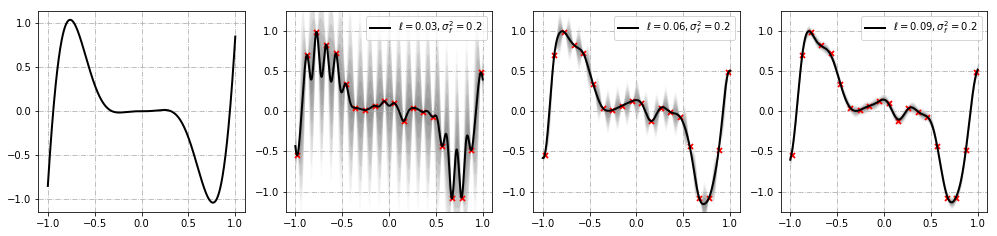

In [4]:
#
# Example 1: Play with hyperparameters (1D, cte sample mean, SExp)
#
# Create noisy data
np.random.seed(12345)
sig2_n = .01
D, n = 1, 20
nl_fun = lambda t: 3. * t**3 * np.cos(5 * t)
nl_obs = lambda t: 3. * t**3 * np.cos(5 * t) + sig2_n**.5 * np.random.normal(size=n)
X = np.linspace(-.98, .98, n).reshape((D, n))                                # D x n
y = nl_obs(X.reshape(n))                                                     # n x 1

Compute_variance = True
Solver_type = 'direct' # {'direct', 'krylov'}

# Set features for estimation
m = 500
Xs = np.linspace(-1, 1, m)                                                             # D x m

# Define cases of hyperparameters
cases = [{'m_f': np.mean(y), 'ell': 0.03, 'sig2_f': 0.2, 'sig2_n':0.00}, 
         {'m_f': np.mean(y), 'ell': 0.06, 'sig2_f': 0.2, 'sig2_n':0.00}, 
         {'m_f': np.mean(y), 'ell': 0.09, 'sig2_f': 0.2, 'sig2_n':0.01}]
ncases = len(cases)

# Compute GPR estimators
fs = []
sig2_s = []
Ky, invM, chol = [], [], []
for icase, case in enumerate(cases):
    sig2_n = case['sig2_n']
    Ks = np.zeros((n, m))                                                              # n x m
    for j in range(m):
        Ks[:, j] = get_kvec(X, Xs[j], case['ell'], case['sig2_f'])
    Ky +=[get_Kmat(X, case['ell'], case['sig2_f']) + case['sig2_n'] * np.identity(n)]  # n x n
    if Solver_type == 'krylov':
        ml = smoothed_aggregation_solver(sp.csr_matrix(Ky[icase]))
        invM += [ml.aspreconditioner(cycle='V')]  
        alpha, _ = sp.linalg.cg(Ky[icase], y - case['m_f'], M=invM[icase])
    elif Solver_type == 'direct':
        chol += [scipy.linalg.cho_factor(Ky[icase])]
        alpha = scipy.linalg.cho_solve(chol[icase], y - case['m_f'])
        
    fs += [np.array(case['m_f'] + Ks.T.dot(alpha))]                                    # m x 1
    if Compute_variance:
        if Solver_type == 'krylov':
            sig2_s += [np.array([sig_SExp(Xs[j], Xs[j], case['ell'], case['sig2_f']) - \
                       Ks[:, j].dot(sp.linalg.cg(Ky[icase], Ks[:, j], M=invM[icase])[0]) for j in range(m)])]
        elif Solver_type == 'direct':
            sig2_s += [np.array([sig_SExp(Xs[j], Xs[j], case['ell'], case['sig2_f']) - \
                       Ks[:, j].dot(scipy.linalg.cho_solve(chol[icase], Ks[:, j])) for j in range(m)])]
                   
nvars = 8
fig, ax = pl.subplots(1, ncases + 1, figsize=(17, 3.7))
ax[0].plot(Xs.reshape(m), nl_fun(Xs.reshape(m)), color='k', lw=2, label=r'$f(x)$')
ax[0].grid(linestyle="-.")
for icase, case in enumerate(cases):
    for r in range(1, nvars + 1):
        ax[icase + 1].fill_between(Xs, fs[icase] - r * sig2_s[icase], fs[icase] + r * sig2_s[icase], lw=0, color='grey', alpha=.4 * (1 - r / nvars))
    ax[icase + 1].plot(X.reshape(n), y, "rx", markersize=5, markeredgewidth=1.8)
    ax[icase + 1].plot(Xs, fs[icase], color='k', lw=2, label=r'$\ell = %g, \sigma_f^2 = %g$' % (case['ell'], case['sig2_f']))
    ax[icase + 1].grid(linestyle="-.")
    ax[icase + 1].legend()
    ax[icase + 1].set_ylim(-1.25, 1.25)
pl.show()

del sig2_n, D, n, X, y, m, Xs, cases, fs, Ks, Ky

In [5]:
#
# Example 2: Play with hyperparameters (2D, cte sample mean, SExp)
#
# Create noisy data
np.random.seed(12345)
sig2_n = .01
D, n = 2, 200
nl_fun = lambda t: 3. * t**3 * np.cos(5 * t)
nl_obs = lambda t: 3. * t**3 * np.cos(5 * t) + sig2_n**.5 * np.random.normal(size=n)
X = -1 + 2 * np.random.rand(D, n)                                                   # D x n
y = nl_obs(np.array([np.linalg.norm(X[:, j]) for j in range(n)]))                   # n x 1

Compute_variance = True
Solver_type = 'direct' # {'direct', 'krylov'}

# Set features for estimation
m0 = 200
m = m0**D
Xs = np.zeros((D, m))                                                               # D x m
base = np.linspace(-1, 1, m0)
for j in range(m0):
    Xs[0, j * m0: (j+1) * m0] = base
    Xs[1, j * m0: (j+1) * m0] = m0 * [base[j]]

# Define cases of hyperparameters
inv_ell2 = [np.array([[0.03**-2, 0.00], [0.00, 0.03**-2]]),
            np.array([[0.10**-2, 0.00], [0.00, 0.10**-2]]),
            np.array([[0.40**-2, 0.00], [0.00, 0.40**-2]])]
sig2_f = [0.20, 0.20, 25]

cases = [{'m_f': np.mean(y), 'ell': np.array([[0.03**-2, 0.00], [0.00, 0.03**-2]]), 'sig2_f': 0.20, 'sig2_n':0.00},
         {'m_f': np.mean(y), 'ell': np.array([[0.10**-2, 0.00], [0.00, 0.10**-2]]), 'sig2_f': 0.20, 'sig2_n':0.00}, 
         {'m_f': np.mean(y), 'ell': np.array([[0.40**-2, 0.00], [0.00, 0.40**-2]]), 'sig2_f': 25.0, 'sig2_n':0.01}]
ncases = len(cases)

# Compute GPR estimators
fs = []
sig2_s = []
invM, chol = [], []
for icase, case in enumerate(cases):
    sig2_n = case['sig2_n']
    Ks = np.zeros((n, m))                                                            # n x m
    for j in range(m):
        Ks[:, j] = get_kvec(X, Xs[:, j], case['ell'], case['sig2_f'])
    Ky = get_Kmat(X, case['ell'], case['sig2_f']) + case['sig2_n'] * np.identity(n)  # n x n
    if Solver_type == 'krylov':
        ml = smoothed_aggregation_solver(sp.csr_matrix(Ky))
        invM += [ml.aspreconditioner(cycle='V')]
        alpha, _ = sp.linalg.cg(Ky, y - case['m_f'], M=invM[icase])
    elif Solver_type == 'direct':
        chol += [scipy.linalg.cho_factor(Ky)]
        alpha = scipy.linalg.cho_solve(chol[icase], y - case['m_f'])
    fs += [np.array(case['m_f'] + Ks.T.dot(alpha))]                                  # m x 1
    
if Compute_variance:
    for icase, case in enumerate(cases):
        if Solver_type == 'krylov':
            sig2_s += [np.array([cov_SExp(Xs[:, j], Xs[:, j], inv_ell2[icase], sig2_f[icase]) - \
                       Ks[:, j].dot(sp.linalg.cg(Ky[icase], Ks[:, j], M=invM[icase])[0]) for j in range(m)])]
        elif Solver_type == 'direct':
            sig2_s += [np.array([cov_SExp(Xs[:, j], Xs[:, j], inv_ell2[icase], sig2_f[icase]) - \
                       Ks[:, j].dot(scipy.linalg.cho_solve(chol[icase], Ks[:, j])) for j in range(m)])]

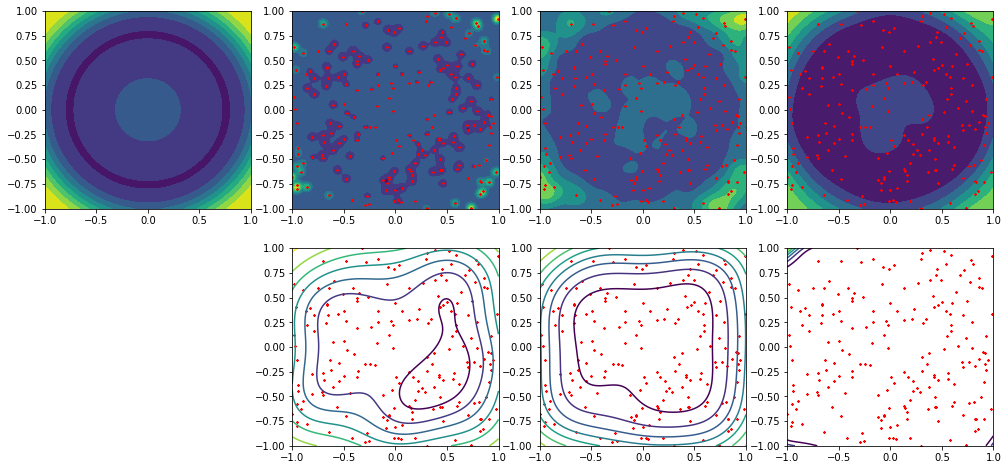

In [6]:
fig, ax = pl.subplots(2, ncases + 1, figsize=(17, 8))
ax[1, 0].axis('off')
cp = ax[0, 0].contourf(Xs[0, :].reshape((m0, m0)), Xs[1, :].reshape((m0, m0)), nl_fun(np.array([np.linalg.norm(Xs[:, j]) for j in range(m)])).reshape((m0, m0)))
for icase, case in enumerate(cases):
    cp = ax[0, icase + 1].contourf(Xs[0, :].reshape((m0, m0)), Xs[1, :].reshape((m0, m0)), fs[icase].reshape((m0, m0)))
    ax[0, icase + 1].scatter(X[0, :], X[1, :], marker='x', color='r', s=3)
    ax[0, icase + 1].set_xlim(-1, 1); ax[0, icase + 1].set_ylim(-1, 1)
    if Compute_variance:
        cp = ax[1, icase + 1].contour(Xs[0, :].reshape((m0, m0)), Xs[1, :].reshape((m0, m0)), sig2_s[icase].reshape((m0, m0)))#, locator=ticker.LogLocator())
        ax[1, icase + 1].scatter(X[0, :], X[1, :], marker='x', color='r', s=3)
        ax[1, icase + 1].set_xlim(-1, 1); ax[1, icase + 1].set_ylim(-1, 1)
pl.show()

#del sig2_n, D, n, X, y, m, Xs, cases, fs, Ks, Ky

## V.5.4 Model Selection for GP regression


### Marginal likelihood:
The marginal likelihood (or evidence) is given by<br>

\begin{align*}
\log p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta})=
-\frac{1}{2}\mathbf{y}^T\mathbf{K}_y^{-1}\mathbf{y}
-\frac{1}{2}\log\det\mathbf{K}_y
-\frac{n}{2}\log 2\pi.
\end{align*}

To set the hyperparameters $\boldsymbol{\theta}$ by maximizing the marginal likelihood, we may use the following derivatives:<br>

\begin{align*}
\partial_{\theta_j}[\log p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta})]=&\;
\frac{1}{2}\mathbf{y}^T\mathbf{K}_y^{-1}\partial_{\theta_j}(\mathbf{K}_y)\mathbf{K}_y^{-1}\mathbf{y}
-\frac{1}{2}\mathrm{tr}(\mathbf{K}_y^{-1}\partial_{\theta_j}(\mathbf{K}_y))\\
=&\;
\frac{1}{2}\mathrm{tr}\left((\boldsymbol{\alpha}\boldsymbol{\alpha}^T-\mathbf{K}_y^{-1})\partial_{\theta_j}(\mathbf{K}_y)\right)
\;\;\;
\mathrm{where}\;\;
\mathbf{K}_y\boldsymbol{\alpha}=\mathbf{y}.
\end{align*}

The maximum likelihood estimator $\underset{\boldsymbol{\theta}}{\mathrm{max}} \log p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta})$ satisfies the optimality condition $\partial_{\theta_j}[\log p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta})]=0$, leading to the following nonlinear (score) equations:<br>

\begin{align*}
\mathrm{tr}\left(\boldsymbol{\alpha}\boldsymbol{\alpha}^T\partial_{\theta_j}(\mathbf{K}_y)-\mathbf{K}_y^{-1}\partial_{\theta_j}(\mathbf{K}_y)\right)=0.
\end{align*}

See Anitescu et al. (2012) for interesting iterative methods in cases $n > 10^5$.

When we know the Cholesky factor $\mathbf{L}$ s.t. $\mathbf{L}\mathbf{L}^T=\mathbf{K}_y$, the we have:<br>

\begin{align*}
\det\mathbf{K}_y=\det(\mathbf{L}\mathbf{L}^T)=\det(\mathbf{L})\det(\mathbf{L}^T)=\det(\mathbf{L})^2
\end{align*}
where $\det\mathbf{L}=\Pi_{i=1}^nL_{ii}$ so that
\begin{align*}
\log\det\mathbf{K}_y=
\log(\det(\mathbf{L})^2)=
2\log\prod_{i=1}^nL_{ii}=
2\sum_{i=1}^n\log L_{ii}=
2 \operatorname{tr}\left(\log\operatorname{diag}(\mathbf{L})\right).
\end{align*}

### Gradient components of marginal likelihood:

Let us assume<br>

\begin{align*}
(\mathbf{K}_y)_{ij}=\sigma_f^2
\exp\left(-\frac{\|\mathbf{x}_i-\mathbf{x}_j\|^2}{2\ell^2}\right)
+\sigma_n^2\delta_{ij}.
\end{align*}

Then, we have<br>
\begin{align*}
\partial_{\ell}(\mathbf{K}_y)_{ij}=&\;
\frac{\|\mathbf{x}_i-\mathbf{x}_j\|^2}{\ell^{3}}
\sigma_f^2
\exp\left(-\frac{\|\mathbf{x}_i-\mathbf{x}_j\|^2}{2\ell^2}\right)=
\frac{\|\mathbf{x}_i-\mathbf{x}_j\|^2}{\ell^{3}}((\mathbf{K}_y)_{ij}
-\sigma_n^2\delta_{ij}),
\;\;\mathrm{or}\;
\partial_\ell\mathbf{K}_y=\ell^{-3}\boldsymbol{\Delta}\circ(\mathbf{K}_y-\sigma_n^2\mathbf{I}_n)
\end{align*}

where
\begin{align}
\boldsymbol{\Delta}:=
\left[
\begin{matrix}
0 & \|\mathbf{x}_1-\mathbf{x}_2\|^2 & \dots & \|\mathbf{x}_1-\mathbf{x}_n\|^2\\
\|\mathbf{x}_2-\mathbf{x}_1\|^2 & 0 & \ddots & \vdots\\
\vdots & \ddots & \ddots & \|\mathbf{x}_{n-1}-\mathbf{x}_n\|^2\\
\|\mathbf{x}_n-\mathbf{x}_1\|^2 & \dots & \|\mathbf{x}_n-\mathbf{x}_{n-1}\|^2 & 0\\
\end{matrix}
\right].
\end{align}

We also have<br>
\begin{align*}
\partial_{\sigma_f^2}(\mathbf{K}_y)_{ij}=&\;
\exp\left(-\frac{\|\mathbf{x}_i-\mathbf{x}_j\|^2}{2\ell^2}\right)=
\sigma_f^{-2}((\mathbf{K}_y)_{ij}
-\sigma_n^2\delta_{ij}).
\end{align*}

The gradient components of the marginal likelihood are then given by<br>

\begin{align*}
\partial_{\ell}[\log p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta})]=
\frac{1}{2}\mathrm{tr}\left((\boldsymbol{\alpha}\boldsymbol{\alpha}^T-\mathbf{K}_y^{-1})\partial_{\ell}(\mathbf{K}_y)\right)=
\frac{\ell^{-3}}{2}\mathrm{tr}\left((\boldsymbol{\alpha}\boldsymbol{\alpha}^T-\mathbf{K}_y^{-1})(\boldsymbol{\Delta}\circ(\mathbf{K}_y-\sigma_n^2\mathbf{I}_n))\right)
\end{align*}

and<br>
\begin{align*}
\partial_{\sigma_f^2}[\log p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta})]=
\frac{\sigma_f^{-2}}{2}\mathrm{tr}\left(\boldsymbol{\alpha}\boldsymbol{\alpha}^T-\mathbf{K}_y^{-1})(\mathbf{K}_y-\sigma_n^2\mathbf{I}_n)\right)
\end{align*}


where $\mathbf{K}_y\boldsymbol{\alpha}=\mathbf{y}$.
Note that if $\sigma_n^2=0$, we have
\begin{align*}
\partial_{\sigma_f^2}[\log p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta})]=
\frac{\sigma_f^{-2}}{2}\mathrm{tr}\left(\boldsymbol{\alpha}\mathbf{y}^T\mathbf{K}_y^{-T}\mathbf{K}_y-\mathbf{I}_n\right)=
\frac{\sigma_f^{-2}}{2}\mathrm{tr}\left(\boldsymbol{\alpha}\mathbf{y}^T-\mathbf{I}_n\right)
\end{align*}

def fun(x, X, y, sig2_n, m_f, invM=None):
    D, n = X.shape
    if D == 1:
        # x[0] = ell
        # x[1] = sig2_f
        ell, sig2_f = x
    elif D > 1:
        # x[0] = ell_1
        # x[1] = ell_2
        # x[2] = sig2_f
        ell = np.array([[x[0]**-2, 0.00], [0.00, x[1]**-2]])
        sig2_f = x[2]
    
    Ky = get_Kmat(X, ell, sig2_f) + sig2_n * np.identity(n)                   # n x n
    
    if Solver_type == 'krylov':
        if invM is None:
            ml = smoothed_aggregation_solver(sp.csr_matrix(Ky))
            alpha = ml.solve(y - m_f)
        else:         
            alpha, _ = sp.linalg.cg(Ky, y - m_f, M=invM)                      # n x 1
        log_detKy2 = np.log(np.linalg.det(Ky))
    
    elif Solver_type == 'direct':
        chol = scipy.linalg.cho_factor(Ky)
        alpha = scipy.linalg.cho_solve(chol, y - m_f)
        log_detKy2 = 2 * np.sum(np.log(np.diag(chol[0])))
    
    marg_lik = - np.dot(y, alpha) / 2 - log_detKy2 / 2 - n * np.log(2 * np.pi) / 2
    
    print(x, -marg_lik)
    
    return - marg_lik

#def jac(x, X, y, sig2_n):
#    # x[0] = ell
#    # x[1] = sig2_f
#    _, n = X.shape                                                     
#    ell, sig2_f = x
#    Ky = get_Kmat(X, ell, sig2_f) + sig2_n * np.identity(n)                  # n x n
#    alpha = np.linalg.solve(Ky, y)                                           # n x 1
#    DoKy = get_D(X) * (Ky - sig2_n * np.identity(n))                         # n x n
#    invKyDoKy = np.zeros((n, n))                                             # n x n
#    for i in range(n):
#        invKyDoKy[:, i] = np.linalg.solve(Ky, DoKy[:, i])
#    dx = np.zeros(2)
#    dx[0] = 1. / (2 * ell**3) * np.trace(np.outer(alpha, alpha).dot(DoKy) - invKyDoKy)
#    dx[1] = 1. / (2 * sig2_f) * np.trace(np.outer(alpha, y) - np.eye(n))
#    return - dx

[0.1 1.4] -18.618365653701147
[0.10000001 1.4       ] -18.618371084578
[0.1        1.40000001] -18.618365553611298
[0.1 1.4] -18.618365653701147
[1.10982852 1.38138909] 533.1589199887009
[1.10982852 1.38138909] 533.1589199887009
[1.10982853 1.38138909] 533.1589218322201
[1.10982852 1.3813891 ] 533.1589197726742
[0.18901073 1.39835955] -31.205853278741174
[0.18901073 1.39835955] -31.205853278741174
[0.18901074 1.39835955] -31.205853986336095
[0.18901073 1.39835957] -31.205853259419598
[0.72407029 1.38374922] 235.12872425246894
[0.72407029 1.38374922] 235.12872425246894
[0.72407031 1.38374922] 235.1287453570498
[0.72407029 1.38374924] 235.12872279910272
[0.22853513 1.3972803 ] -32.73605222024932
[0.22853513 1.3972803 ] -32.73605222024932
[0.22853515 1.3972803 ] -32.73605241786723
[0.22853513 1.39728031] -32.73605222719905
[0.46132083 1.4054668 ] 31.91159718325082
[0.46132083 1.4054668 ] 31.91159718325082
[0.46132085 1.4054668 ] 31.9116068425908
[0.46132083 1.40546681] 31.911596688602742


[0.33196392 7.84680267] -33.908390163424144
[0.33196394 7.84680267] -33.908390163381824
[0.33196392 7.84680269] -33.90839016342268
[0.3319638  7.84679835] -33.90839016362284
[0.3319638  7.84679835] -33.90839016362284
[0.33196382 7.84679835] -33.90839016358446
[0.3319638  7.84679836] -33.90839016362435
[0.33196375 7.84679669] -33.908390163697206
[0.33196375 7.84679669] -33.908390163697206
[0.33196377 7.84679669] -33.908390163657245
[0.33196375 7.8467967 ] -33.90839016369573
[0.33196375 7.84679637] -33.90839016371157
[0.33196375 7.84679637] -33.90839016371157
[0.33196376 7.84679637] -33.908390163668244
[0.33196375 7.84679638] -33.90839016371686
[0.33196374 7.84679622] -33.90839016371558
[0.33196374 7.84679622] -33.90839016371558
[0.33196376 7.84679622] -33.90839016367414
[0.33196374 7.84679624] -33.90839016371886
[0.33196374 7.84679628] -33.908390163713506
[0.33196374 7.84679628] -33.908390163713506
[0.33196376 7.84679628] -33.90839016367774
[0.33196374 7.8467963 ] -33.90839016371373
[0.

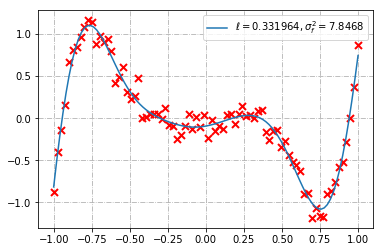

In [8]:
#
# Example 3: Optimization-based hyperparameter estimation (1D, cte sample mean, SExp)
#
# Create noisy data
np.random.seed(12345)
sig2_n = .01
D, n = 1, 80
nl_fun = lambda t: 3. * t**3 * np.cos(5 * t) + sig2_n**.5 * np.random.normal(size=n)
X = np.linspace(-1, 1, n).reshape((D, n))                                     # D x n
y = nl_fun(X.reshape(n))                                                      # n x 1
m_f = np.mean(y)

Solver_type = 'direct' # {'direct', 'krylov'}

if Solver_type == 'krylov':
    # Set preconditioner
    Ky = get_Kmat(X, .1, 1.4) + sig2_n * np.identity(n)                       # n x n
    ml = smoothed_aggregation_solver(sp.csr_matrix(Ky))
    invM = ml.aspreconditioner(cycle='V')
elif Solver_type == 'direct':
    invM = None

args = (X, y, sig2_n, m_f, invM)
x0 = np.array([.1, 1.4])
res = minimize(fun, x0, args=args, method='CG')
ell, sig2_f = res.x
print(res)
print('ell, sig2_f = %g, %g' % (ell, sig2_f))

# Set features for estimation
m = 100
Xs = np.linspace(-1, 1, m)                                                    # D x m

# Compute GPR estimator
fs = []
Ks = np.zeros((n, m))                                                         # n x m
for j in range(m):
    Ks[:, j] = get_kvec(X, Xs[j], ell, sig2_f)
Ky = get_Kmat(X, ell, sig2_f) + sig2_n * np.identity(n)                       # n x n
if Solver_type == 'krylov':
    alpha, _ = sp.linalg.cg(Ky, y - m_f, M=invM)
elif Solver_type == 'direct':
    chol = scipy.linalg.cho_factor(Ky)
    alpha = scipy.linalg.cho_solve(chol, y - m_f)
fs = np.array(m_f + Ks.T.dot(alpha))   

ax = pl.subplot()
ax.plot(X.reshape(n), y, "rx", markersize=7, markeredgewidth=2)
ax.plot(Xs, fs, label=r'$\ell = %g, \sigma_f^2 = %g$' % (ell, sig2_f))
ax.grid(linestyle="-.")
pl.legend()
pl.show()

In [9]:
#
# Example 4: Optimization-based hyperparameter estimation (2D, cte sample mean, SExp)
#
# Create noisy data
np.random.seed(12345)
sig2_n = .01
D, n = 2, 200
nl_fun = lambda t: 3. * t**3 * np.cos(5 * t)
nl_obs = lambda t: 3. * t**3 * np.cos(5 * t) + sig2_n**.5 * np.random.normal(size=n)
X = -1 + 2 * np.random.rand(D, n)                                            # D x n
y = nl_obs(np.array([np.linalg.norm(X[:, j]) for j in range(n)]))            # n x 1
m_f = np.mean(y)

Compute_variance = True
Solver_type = 'direct' # {'direct', 'krylov'}

if Solver_type == 'krylov':
    # Set preconditioner
    inv_ell2 = np.array([[.12**-2, 0.00], [0.00, .12**-2]])
    Ky = get_Kmat(X, inv_ell2, .5) + sig2_n * np.identity(n)                 # n x n
    ml = smoothed_aggregation_solver(sp.csr_matrix(Ky))
    invM = ml.aspreconditioner(cycle='V')       
elif Solver_type == 'direct':
    invM = None

args = (X, y, sig2_n, m_f, invM)
x0 = np.array([0.20, 0.20, 0.5])
res = minimize(fun, x0, args=args, method='CG')
ell_1, ell_2, sig2_f = res.x
inv_ell2 = np.array([[ell_1**-2, 0.00], [0.00, ell_2**-2]])
print(res)
print('ell_1, ell_2, sig2_f = %g, %g, %g' % (ell_1, ell_2, sig2_f))

# Set simulated features
m0 = 200
m = m0**D
Xs = np.zeros((D, m))                                                        # D x m
base = np.linspace(-1, 1, m0)
for j in range(m0):
    Xs[0, j * m0: (j+1) * m0] = base
    Xs[1, j * m0: (j+1) * m0] = m0 * [base[j]]

# Compute GPR estimator
Ks = np.zeros((n, m))                                                        # n x m
for j in range(m):
    Ks[:, j] = get_kvec(X, Xs[:, j], inv_ell2, sig2_f)
Ky = get_Kmat(X, inv_ell2, sig2_f) + sig2_n * np.identity(n)                 # n x n
if Solver_type == 'krylov':
    alpha, _ = sp.linalg.cg(Ky, y - m_f, M=invM)
elif Solver_type == 'direct':
    chol = scipy.linalg.cho_factor(Ky)
    alpha = scipy.linalg.cho_solve(chol, y - m_f)
fs = np.array(m_f + Ks.T.dot(alpha))   

[0.2 0.2 0.5] 191.95816125233293
[0.20000001 0.2        0.5       ] 191.95816178598275
[0.2        0.20000001 0.5       ] 191.95816087060658
[0.2        0.2        0.50000001] 191.95815582166458
[0.2 0.2 0.5] 191.95816125233293
[0.10146791 0.27048123 1.50270825] 154.9284524256457
[0.10146791 0.27048123 1.50270825] 154.9284524256457
[0.10146793 0.27048123 1.50270825] 154.9284336121978
[0.10146791 0.27048124 1.50270825] 154.9284532868895
[0.10146791 0.27048123 1.50270826] 154.92845202148894
[0.15525762 0.28691523 1.79168233] 95.55426260655318
[0.15525762 0.28691523 1.79168233] 95.55426260655318
[0.15525764 0.28691523 1.79168233] 95.55425158888863
[0.15525762 0.28691524 1.79168233] 95.55426365020017
[0.15525762 0.28691523 1.79168235] 95.55426230105573
[0.24988904 0.31582732 2.30007004] 48.09193890462586
[0.24988904 0.31582732 2.30007004] 48.09193890462586
[0.24988905 0.31582732 2.30007004] 48.091935916786866
[0.24988904 0.31582733 2.30007004] 48.09194018411017
[0.24988904 0.31582732 2.300

[ 0.36266513  0.39932113 11.93169794] 1.490149924045653
[ 0.42564427  0.36286568 13.70045785] 4.20110478718135
[ 0.42564427  0.36286568 13.70045785] 4.20110478718135
[ 0.42564428  0.36286568 13.70045785] 4.2011061576184545
[ 0.42564427  0.36286569 13.70045785] 4.201103275509553
[ 0.42564427  0.36286568 13.70045787] 4.201104780251541
[ 0.38063631  0.38891852 12.43641599] 0.7890783409737594
[ 0.38063631  0.38891852 12.43641599] 0.7890783409737594
[ 0.38063633  0.38891852 12.43641599] 0.7890780853049648
[ 0.38063631  0.38891853 12.43641599] 0.789077720310587
[ 0.38063631  0.38891852 12.436416  ] 0.7890783359352156
[ 0.3926094   0.41798446 12.43665194] 1.0604709143721323
[ 0.3926094   0.41798446 12.43665194] 1.0604709143721323
[ 0.39260942  0.41798446 12.43665194] 1.0604717703020583
[ 0.3926094   0.41798448 12.43665194] 1.0604715274639887
[ 0.3926094   0.41798446 12.43665196] 1.060470899732394
[ 0.3855758   0.40090966 12.43651333] 0.4980649684621028
[ 0.3855758   0.40090966 12.43651333] 0.

[ 0.40549778  0.43602284 21.89336071] -1.739080251827403
[ 0.40549777  0.43602285 21.89336071] -1.73908040040007
[ 0.40549777  0.43602284 21.89336072] -1.7390802981178126
[ 0.40345291  0.44095863 21.89066735] -1.7590229803353168
[ 0.40345291  0.44095863 21.89066735] -1.7590229803353168
[ 0.40345293  0.44095863 21.89066735] -1.7590229807680373
[ 0.40345291  0.44095864 21.89066735] -1.7590229808940876
[ 0.40345291  0.44095863 21.89066736] -1.7590229810874973
[ 0.40377398  0.44111605 21.89119621] -1.7588149217765192
[ 0.40377398  0.44111605 21.89119621] -1.7588149217765192
[ 0.40377399  0.44111605 21.89119621] -1.7588149028719329
[ 0.40377398  0.44111606 21.89119621] -1.758814914347255
[ 0.40377398  0.44111605 21.89119622] -1.7588149226469625
[ 0.40347954  0.44097169 21.89071121] -1.7590247768365828
[ 0.40347954  0.44097169 21.89071121] -1.7590247768365828
[ 0.40347956  0.44097169 21.89071121] -1.7590247756920405
[ 0.40347954  0.4409717  21.89071121] -1.7590247767381015
[ 0.40347954  0.44

[ 0.40765345  0.44936706 24.58900881] -1.833221254891356
[ 0.40765128  0.44936837 24.58904077] -1.8332215790076987
[ 0.40765128  0.44936837 24.58904077] -1.8332215790076987
[ 0.40765129  0.44936837 24.58904077] -1.8332215784866719
[ 0.40765128  0.44936838 24.58904077] -1.8332215789795896
[ 0.40765128  0.44936837 24.58904079] -1.8332215791174065
[ 0.40764257  0.44937357 24.58916869] -1.8332227250806739
[ 0.40764257  0.44937357 24.58916869] -1.8332227250806739
[ 0.40764258  0.44937357 24.58916869] -1.8332227249244397
[ 0.40764257  0.44937358 24.58916869] -1.8332227250815833
[ 0.40764257  0.44937357 24.5891687 ] -1.8332227251501934
[ 0.40740611  0.44937495 24.5892739 ] -1.8331269045279726
[ 0.40740611  0.44937495 24.5892739 ] -1.8331269045279726
[ 0.40740612  0.44937495 24.5892739 ] -1.8331269167689186
[ 0.40740611  0.44937496 24.5892739 ] -1.833126907514952
[ 0.40740611  0.44937495 24.58927392] -1.8331269046106229
[ 0.40763906  0.44937359 24.58917025] -1.833222738447006
[ 0.40763906  0.4

[ 0.40848178  0.45124327 25.18627499] -1.8355266159298083
[ 0.40848179  0.45124327 25.18627499] -1.8355266153887158
[ 0.40848178  0.45124328 25.18627499] -1.8355266139570858
[ 0.40848178  0.45124327 25.18627501] -1.8355266158527854
[ 0.4084871   0.45123709 25.18752604] -1.8355280682602597
[ 0.4084871   0.45123709 25.18752604] -1.8355280682602597
[ 0.40848712  0.45123709 25.18752604] -1.8355280677189114
[ 0.4084871   0.4512371  25.18752604] -1.83552806646901
[ 0.4084871   0.45123709 25.18752605] -1.8355280682365276
[ 0.40848729  0.45123687 25.18757013] -1.8355281166771817
[ 0.40848729  0.45123687 25.18757013] -1.8355281166771817
[ 0.40848731  0.45123687 25.18757013] -1.8355281160878292
[ 0.40848729  0.45123689 25.18757013] -1.835528114890593
[ 0.40848729  0.45123687 25.18757015] -1.8355281166755901
[ 0.40835737  0.45084301 25.18756978] -1.83538800062135
[ 0.40835737  0.45084301 25.18756978] -1.83538800062135
[ 0.40835738  0.45084301 25.18756978] -1.8353880117250299
[ 0.40835737  0.45084

[ 0.40849573  0.45115741 25.18757174] -1.8355326326249042
[ 0.40849581  0.45115738 25.18757173] -1.8355326326640409
[ 0.40849576  0.4511574  25.18757172] -1.8355326326922352
[ 0.40849576  0.4511574  25.18757172] -1.8355326326922352
[ 0.40849577  0.4511574  25.18757172] -1.835532632626638
[ 0.40849576  0.45115742 25.18757172] -1.8355326326432078
[ 0.40849576  0.4511574  25.18757174] -1.8355326326820602
[ 0.40849574  0.45115741 25.18757172] -1.8355326327508408
[ 0.40849574  0.45115741 25.18757172] -1.8355326327508408
[ 0.40849576  0.45115741 25.18757172] -1.8355326326597492
[ 0.40849574  0.45115742 25.18757172] -1.8355326325431633
[ 0.40849574  0.45115741 25.18757174] -1.835532632693031
[ 0.40849574  0.45115741 25.18757172] -1.8355326326615398
[ 0.40849574  0.45115741 25.18757172] -1.835532632604668
[ 0.40849574  0.45115741 25.18757172] -1.8355326326613408
[ 0.40849574  0.45115741 25.18757172] -1.8355326326696684
[ 0.40849574  0.45115741 25.18757172] -1.8355326326734769
[ 0.40849574  0.4

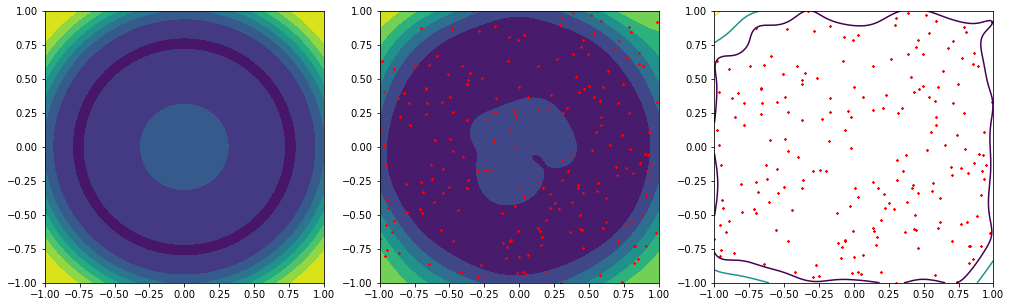

In [10]:
if Compute_variance:
    if Solver_type == 'krylov':
        sig2_s = np.array([cov_SExp(Xs[:, j], Xs[:, j], inv_ell2, sig2_f) - \
                   Ks[:, j].dot(sp.linalg.cg(Ky[icase], Ks[:, j], M=invM[icase])[0]) for j in range(m)])
    elif Solver_type == 'direct':
        sig2_s = np.array([cov_SExp(Xs[:, j], Xs[:, j], inv_ell2, sig2_f) - \
                   Ks[:, j].dot(scipy.linalg.cho_solve(chol, Ks[:, j])) for j in range(m)])
        
fig, ax = pl.subplots(1, 3, figsize=(17, 5))
f = nl_fun(np.array([np.linalg.norm(Xs[:, j]) for j in range(m)]))        # n x 1
cp = ax[0].contourf(Xs[0, :].reshape((m0, m0)), Xs[1, :].reshape((m0, m0)), nl_fun(np.array([np.linalg.norm(Xs[:, j]) for j in range(m)])).reshape((m0, m0)))
cp = ax[1].contourf(Xs[0, :].reshape((m0, m0)), Xs[1, :].reshape((m0, m0)), fs.reshape((m0, m0)))
ax[1].scatter(X[0, :], X[1, :], marker='x', color='r', s=3)
cp = ax[2].contour(Xs[0, :].reshape((m0, m0)), Xs[1, :].reshape((m0, m0)), sig2_s.reshape((m0, m0)), locator=ticker.LogLocator())
ax[2].scatter(X[0, :], X[1, :], marker='x', color='r', s=3)
ax[0].set_xlim(-1, 1); ax[1].set_xlim(-1, 1); ax[2].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1); ax[1].set_ylim(-1, 1); ax[2].set_ylim(-1, 1)
pl.show()